This example is the simplest form of using an RBF kernel in an `VariationalGP` module for classification. This basic model is usable when there is not much training data and no advanced techniques are required.

In this example, we’re modeling a unit wave with period 1/2 centered with positive values @ x=0

Variational inference uses the assumption that the posterior distribution factors multiplicatively over the input variables. This makes approximating the distribution via the KL divergence possible to obtain a fast approximation to the posterior. For a good explanation of variational techniques, sections 4-6 of the following may be useful: https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

In [6]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [7]:
from torch.autograd import Variable
# Grid points are [0,1] every 1/9
train_x = Variable(torch.linspace(0, 1, 10))
# Labels are unit wave with period 1/2 centered with positive values @ x=0
train_y = Variable(torch.sign(torch.cos(train_x.data * (4 * math.pi))))

In [11]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [15]:
# Basic classification model with variational inference
class GPClassificationModel(gpytorch.models.VariationalGP):
    def __init__(self, train_x):
        super(GPClassificationModel, self).__init__(train_x)
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-1e-5, 1e-5))
        self.covar_module = RBFKernel(
            log_lengthscale_prior=SmoothedBoxPrior(math.exp(-5), math.exp(6), sigma=0.1, log_transform=True)
        )
        self.register_parameter(
            name="log_outputscale",
            parameter=torch.nn.Parameter(torch.Tensor([0])),
            prior=SmoothedBoxPrior(math.exp(-5), math.exp(6), sigma=0.1, log_transform=True),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) * self.log_outputscale.exp()
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred
# Initialize model and likelihood
model = GPClassificationModel(train_x.data)
likelihood = BernoulliLikelihood()

In [16]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=len(train_y))

training_iter = 50
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter 1/50 - Loss: 326.092   log_lengthscale: 0.000
Iter 2/50 - Loss: 229.205   log_lengthscale: -0.100
Iter 3/50 - Loss: 147.732   log_lengthscale: -0.200
Iter 4/50 - Loss: 94.309   log_lengthscale: -0.297
Iter 5/50 - Loss: 58.450   log_lengthscale: -0.393
Iter 6/50 - Loss: 34.128   log_lengthscale: -0.487
Iter 7/50 - Loss: 20.241   log_lengthscale: -0.579
Iter 8/50 - Loss: 14.262   log_lengthscale: -0.669
Iter 9/50 - Loss: 12.604   log_lengthscale: -0.757
Iter 10/50 - Loss: 12.035   log_lengthscale: -0.842
Iter 11/50 - Loss: 11.015   log_lengthscale: -0.924
Iter 12/50 - Loss: 10.255   log_lengthscale: -1.004
Iter 13/50 - Loss: 9.753   log_lengthscale: -1.081
Iter 14/50 - Loss: 9.735   log_lengthscale: -1.155
Iter 15/50 - Loss: 7.783   log_lengthscale: -1.227
Iter 16/50 - Loss: 6.957   log_lengthscale: -1.297
Iter 17/50 - Loss: 5.993   log_lengthscale: -1.363
Iter 18/50 - Loss: 5.237   log_lengthscale: -1.427
Iter 19/50 - Loss: 4.902   log_lengthscale: -1.487
Iter 20/50 - Loss: 4.965  

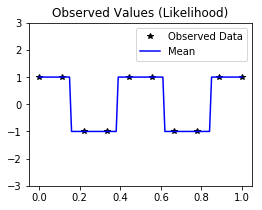

In [17]:
# Go into eval mode
model.eval()
likelihood.eval()

# Initialize fig and axes for plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test x are regularly spaced by 0.01 0,1 inclusive
test_x = Variable(torch.linspace(0, 1, 101))
## Not sure why this is with... Get Bernoulli prediction
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plotting function
# A lot of this should be consolidated as helper between different notebooks
def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot square wave predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')